In [1]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

In [3]:
pip install hdbscan

   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import hdbscan
import matplotlib.pyplot as plt

In [5]:
DATA_PATH = Path('C:/Users/sande/OneDrive/Desktop/Deep Learning/Time Series Forecasting/egrid_all_plants_1996-2023.parquet')
TARGET_YEAR = 2023
N_CLUSTERS = 5
RANDOM_STATE = 42

CLUSTERING ANALYSIS - PRODUCTION RUN
Loading 2023 data...
Loaded 12,613 plants

Clustering 3,273 plants

[1/3] Training K-Means (K=5)...
  Silhouette Score: 0.464
  Cluster sizes: [1633, 1227, 1, 1, 411]

[2/3] Training GMM (K=5)...
  BIC: -35156.5
  Uncertain assignments (prob < 0.7): 20 (0.6%)
  Cluster sizes: [132, 1234, 1195, 1, 711]

[3/3] Training HDBSCAN (min_size=50)...
  Found 2 natural clusters
  Noise/outliers: 359 (11.0%)
  Cluster sizes: [425, 2489]

K-Means CLUSTER PROFILES
 Cluster  Size  Med_Carbon  Med_CapFactor  Med_Generation
       0  1633    0.489152       0.420304       12.840488
       1  1227    0.816667       0.005605        6.047372
       2     1   82.969575       0.003628        6.755769
       3     1  211.752000       0.000027        0.693147
       4   411    0.000000       0.581068       10.296475

GMM CLUSTER PROFILES
 Cluster  Size  Med_Carbon  Med_CapFactor  Med_Generation
       0   132    2.168343       0.000960        4.848101
       1  1234    0.4

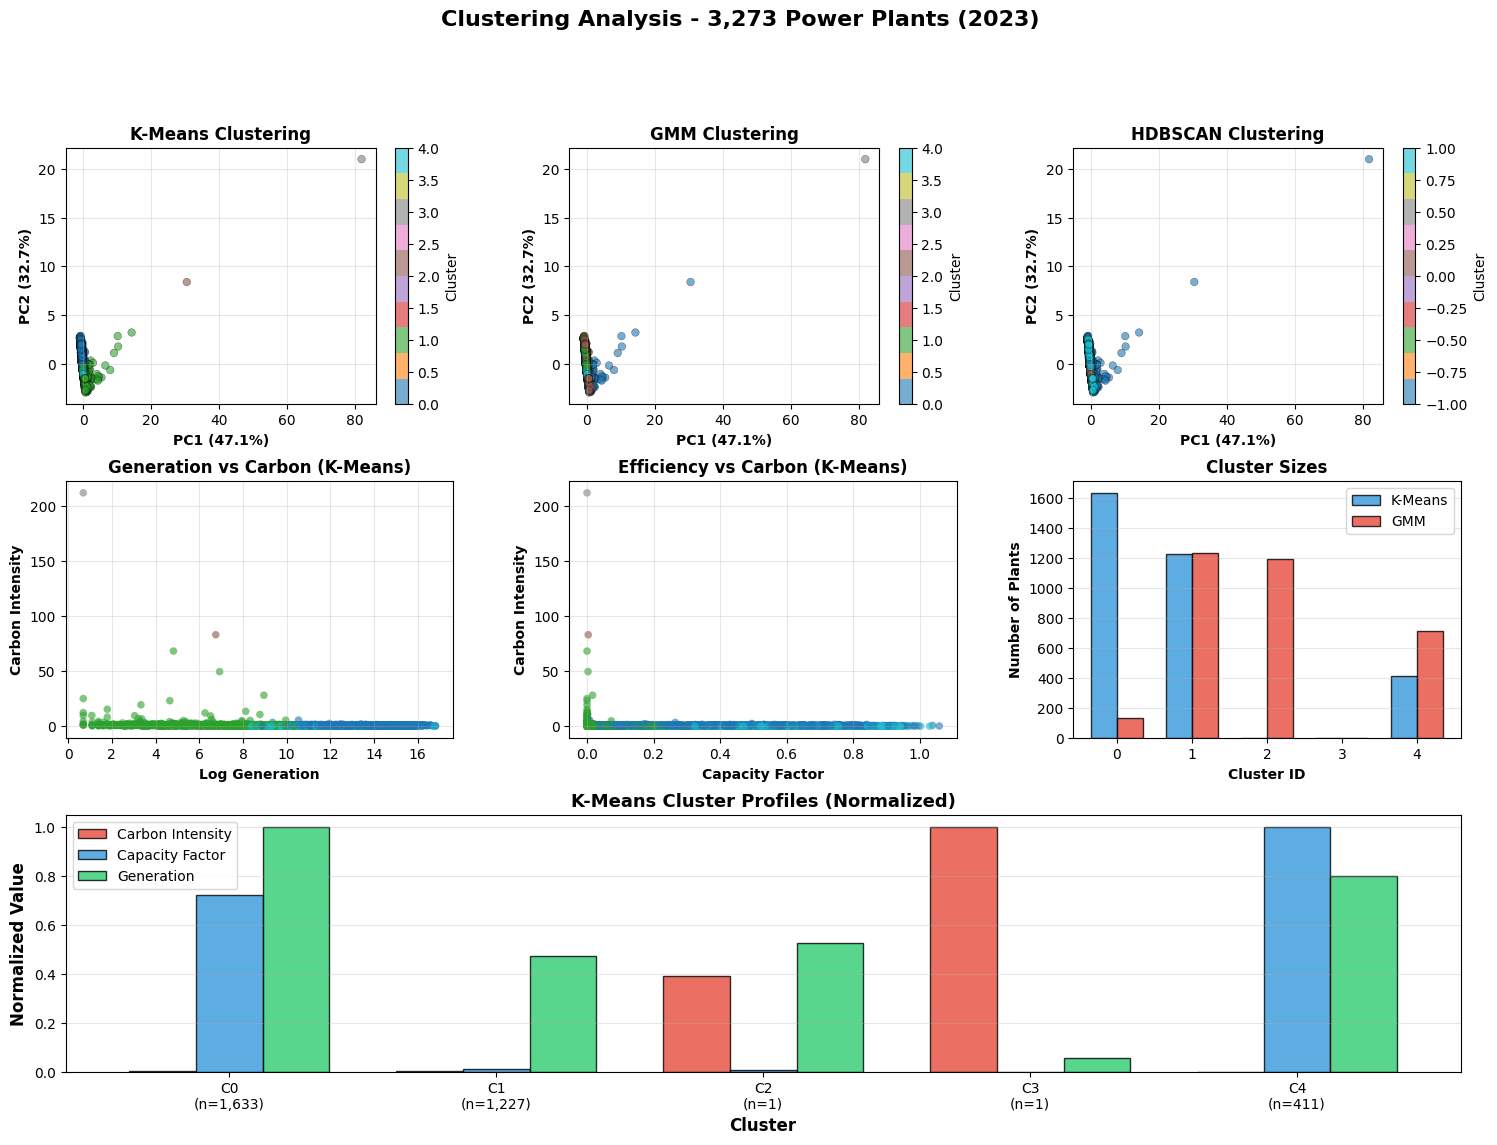

In [6]:
def load_and_prepare_data(year):
    print(f"Loading {year} data...")
    plants = pd.read_parquet(DATA_PATH)
    df = plants[plants['data_year'] == year].copy()
    gen = pd.to_numeric(df['Plant annual net generation (MWh)'], errors='coerce')
    co2 = pd.to_numeric(df['Plant annual CO2 emissions (tons)'], errors='coerce')
    nox = pd.to_numeric(df[[c for c in df.columns if 'NOx' in c and 'annual' in c and 'tons' in c][0]], errors='coerce')
    so2 = pd.to_numeric(df[[c for c in df.columns if 'SO2' in c and 'annual' in c and 'tons' in c][0]], errors='coerce')
    capacity = pd.to_numeric(df['Plant nameplate capacity (MW)'], errors='coerce')
    df['carbon_intensity'] = np.where(gen > 0, co2 / gen, np.nan)
    df['nox_intensity'] = np.where(gen > 0, nox / gen, np.nan)
    df['so2_intensity'] = np.where(gen > 0, so2 / gen, np.nan)
    df['capacity_factor'] = np.where(capacity > 0, gen / (capacity * 8760), np.nan)
    df['log_generation'] = np.log1p(gen)
    df['log_co2'] = np.log1p(co2)
    print(f"Loaded {len(df):,} plants")
    return df

def find_optimal_k(X_scaled, k_range=range(2,11)):
    """Find optimal number of clusters"""
    print("\nFinding optimal K...")
    results = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled,labels)
        calinski = calinski_harabasz_score(X_scaled, labels)
        results.append({
            'k':k,
            'silhouette': silhouette,
            'calinski': calinski,
            'inertia': kmeans.inertia_
        })
        print(f"  K={k}: Silhouette={silhouette:.3f}, Calinski={calinski:.1f}")
    return pd.DataFrame(results)

def train_kmeans(X_scaled, n_clusters):
    """Train K-Means clustering"""
    print(f"\n[1/3] Training K-Means (K={n_clusters})...")
    model = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=20)
    labels = model.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    print(f"  Silhouette Score: {silhouette:.3f}")
    print(f"  Cluster sizes: {pd.Series(labels).value_counts().sort_index().tolist()}")
    return model, labels

def train_gmm(X_scaled, n_components):
    """Train Gaussian Mixture Model"""
    print(f"\n[2/3] Training GMM (K={n_components})...")
    model = GaussianMixture(
        n_components = n_components,
        covariance_type = 'full',
        random_state = RANDOM_STATE,
        n_init = 10
    )
    model.fit(X_scaled)
    labels = model.predict(X_scaled)
    probas = model.predict_proba(X_scaled)
    max_probas = probas.max(axis=1)
    uncertain = (max_probas < 0.7).sum()
    print(f"  BIC: {model.bic(X_scaled):.1f}")
    print(f"  Uncertain assignments (prob < 0.7): {uncertain:,} ({uncertain/len(X_scaled)*100:.1f}%)")
    print(f"  Cluster sizes: {pd.Series(labels).value_counts().sort_index().tolist()}")
    return model, labels, max_probas

def train_hdbscan(X_scaled, min_cluster_size=50):
    """Train HDBSCAN"""
    print(f"\n[3/3] Training HDBSCAN (min_size={min_cluster_size})...")
    model = hdbscan.HDBSCAN(
        min_cluster_size = min_cluster_size,
        min_samples = 10,
        metric='euclidean'
    )
    labels = model.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    print(f"  Found {n_clusters} natural clusters")
    print(f"  Noise/outliers: {n_noise:,} ({n_noise/len(labels)*100:.1f}%)")
    if n_clusters > 0:
        valid_labels = labels[labels!=-1]
        print(f"  Cluster sizes: {pd.Series(valid_labels).value_counts().sort_index().tolist()}")
    return model, labels

def profile_clusters(df, labels, n_clusters, method_name='K-Means'):
    """Generate cluster profiles"""
    print(f"\n{method_name} CLUSTER PROFILES")
    print("=" * 80)
    df_labeled = df.copy()
    df_labeled['cluster'] = labels
    if -1 in labels:
        df_clustered = df_labeled[df_labeled['cluster']!=-1]
        actual_clusters = sorted(df_clustered['cluster'].unique())
    else:
        df_clustered = df_labeled
        actual_clusters = range(n_clusters)
    profiles = []
    for cluster_id in actual_clusters:
        cluster_data = df_clustered[df_clustered['cluster']==cluster_id]
        profile = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Med_Carbon': cluster_data['carbon_intensity'].median(),
            'Med_CapFactor': cluster_data['capacity_factor'].median(),
            'Med_Generation': cluster_data['log_generation'].median()
        }
        profiles.append(profile)
    profile_df = pd.DataFrame(profiles)
    print(profile_df.to_string(index=False))
    return profile_df

def visualize_results(df, kmeans_labels, gmm_labels, hdbscan_labels, X_scaled, features):
    """Create comprehensive visualization"""
    print("\nGenerating visualizations...")
    
    # PCA for visualization
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Row 1: PCA projections
    ax1 = fig.add_subplot(gs[0, 0])
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                          cmap='tab10', alpha=0.6, s=30, edgecolors='black', linewidths=0.3)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
    ax1.set_title('K-Means Clustering', fontsize=12, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, 
                          cmap='tab10', alpha=0.6, s=30, edgecolors='black', linewidths=0.3)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
    ax2.set_title('GMM Clustering', fontsize=12, fontweight='bold')
    plt.colorbar(scatter2, ax=ax2, label='Cluster')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[0, 2])
    # For HDBSCAN, use -1 for noise
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=hdbscan_labels, 
                          cmap='tab10', alpha=0.6, s=30, edgecolors='black', linewidths=0.3)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
    ax3.set_title('HDBSCAN Clustering', fontsize=12, fontweight='bold')
    plt.colorbar(scatter3, ax=ax3, label='Cluster')
    ax3.grid(True, alpha=0.3)
    
    # Row 2: Feature space views
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.scatter(df['log_generation'], df['carbon_intensity'], 
               c=kmeans_labels, cmap='tab10', alpha=0.6, s=30, edgecolors='none')
    ax4.set_xlabel('Log Generation', fontweight='bold')
    ax4.set_ylabel('Carbon Intensity', fontweight='bold')
    ax4.set_title('Generation vs Carbon (K-Means)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(df['capacity_factor'], df['carbon_intensity'], 
               c=kmeans_labels, cmap='tab10', alpha=0.6, s=30, edgecolors='none')
    ax5.set_xlabel('Capacity Factor', fontweight='bold')
    ax5.set_ylabel('Carbon Intensity', fontweight='bold')
    ax5.set_title('Efficiency vs Carbon (K-Means)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Cluster size comparison
    ax6 = fig.add_subplot(gs[1, 2])
    kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index()
    gmm_counts = pd.Series(gmm_labels).value_counts().sort_index()
    
    x = np.arange(len(kmeans_counts))
    width = 0.35
    
    ax6.bar(x - width/2, kmeans_counts.values, width, label='K-Means', 
           color='#3498db', alpha=0.8, edgecolor='black')
    ax6.bar(x + width/2, gmm_counts.values, width, label='GMM', 
           color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax6.set_xlabel('Cluster ID', fontweight='bold')
    ax6.set_ylabel('Number of Plants', fontweight='bold')
    ax6.set_title('Cluster Sizes', fontsize=12, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(kmeans_counts.index)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Row 3: Cluster profiles
    ax7 = fig.add_subplot(gs[2, :])
    
    # Compute cluster profiles
    df_temp = df.copy()
    df_temp['cluster'] = kmeans_labels
    
    profiles = []
    for i in sorted(df_temp['cluster'].unique()):
        cluster_data = df_temp[df_temp['cluster'] == i]
        profiles.append({
            'Cluster': f'C{i}',
            'Size': len(cluster_data),
            'Carbon\nIntensity': cluster_data['carbon_intensity'].median(),
            'Capacity\nFactor': cluster_data['capacity_factor'].median(),
            'Generation\n(log)': cluster_data['log_generation'].median()
        })
    
    profile_df = pd.DataFrame(profiles)
    
    # Normalize for visualization
    x_pos = np.arange(len(profile_df))
    width = 0.25
    
    norm_carbon = profile_df['Carbon\nIntensity'] / profile_df['Carbon\nIntensity'].max()
    norm_cap = profile_df['Capacity\nFactor'] / profile_df['Capacity\nFactor'].max()
    norm_gen = profile_df['Generation\n(log)'] / profile_df['Generation\n(log)'].max()
    
    ax7.bar(x_pos - width, norm_carbon, width, label='Carbon Intensity', 
           color='#e74c3c', alpha=0.8, edgecolor='black')
    ax7.bar(x_pos, norm_cap, width, label='Capacity Factor', 
           color='#3498db', alpha=0.8, edgecolor='black')
    ax7.bar(x_pos + width, norm_gen, width, label='Generation', 
           color='#2ecc71', alpha=0.8, edgecolor='black')
    
    ax7.set_xlabel('Cluster', fontweight='bold', fontsize=12)
    ax7.set_ylabel('Normalized Value', fontweight='bold', fontsize=12)
    ax7.set_title('K-Means Cluster Profiles (Normalized)', fontsize=13, fontweight='bold')
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels([f"{row['Cluster']}\n(n={row['Size']:,})" 
                         for _, row in profile_df.iterrows()])
    ax7.legend(fontsize=10)
    ax7.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Clustering Analysis - {len(df):,} Power Plants ({TARGET_YEAR})',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('03_clustering_results.png', dpi=300, bbox_inches='tight')
    print("  Saved: 03_clustering_results.png")

def export_clusters(df, labels, output_path='plant_clusters.csv'):
    df_export = df.copy()
    df_export['cluster'] = labels
    export_cols = ['Plant name', 'Plant state abbreviation', 'Plant primary fuel category',
                   'cluster', 'carbon_intensity', 'capacity_factor', 'log_generation']
    export_cols = [c for c in export_cols if c in df_export.columns]
    df_export[export_cols].to_csv(output_path, index=False)
    print(f"\nExported cluster assignments to: {output_path}")

def main():
    """Main execution"""
    print("=" * 80)
    print("CLUSTERING ANALYSIS - PRODUCTION RUN")
    print("=" * 80)
    df = load_and_prepare_data(TARGET_YEAR)
    features = ['log_generation', 'log_co2', 'carbon_intensity', 
                'capacity_factor', 'nox_intensity', 'so2_intensity']
    X = df[features].dropna()
    df_clean = df.loc[X.index].copy()
    print(f"\nClustering {len(X):,} plants")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # k_results = find_optimal_k(X_scaled)
    kmeans_model, kmeans_labels = train_kmeans(X_scaled, N_CLUSTERS)
    gmm_model, gmm_labels, gmm_probas = train_gmm(X_scaled, N_CLUSTERS)
    hdbscan_model, hdbscan_labels = train_hdbscan(X_scaled)
    kmeans_profiles = profile_clusters(df_clean, kmeans_labels, N_CLUSTERS, 'K-Means')
    gmm_profiles = profile_clusters(df_clean, gmm_labels, N_CLUSTERS, 'GMM')
    hdbscan_n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    if hdbscan_n_clusters > 0:
        hdbscan_profiles = profile_clusters(df_clean, hdbscan_labels, hdbscan_n_clusters, 'HDBSCAN')
    visualize_results(df_clean, kmeans_labels, gmm_labels, hdbscan_labels, X_scaled, features)
    export_clusters(df_clean, kmeans_labels)
    print("\n" + "=" * 80)
    print("✓ Complete!")
    print("=" * 80)
    return {
        'data': df_clean,
        'features': X,
        'models': {
            'kmeans': kmeans_model,
            'gmm': gmm_model,
            'hdbscan': hdbscan_model
        },
        'labels': {
            'kmeans': kmeans_labels,
            'gmm': gmm_labels,
            'hdbscan': hdbscan_labels
        },
        'profiles': {
            'kmeans': kmeans_profiles,
            'gmm': gmm_profiles
        }
    }

if __name__=='__main__':
    results = main()